In [264]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import folium
from matplotlib import font_manager, rc

In [265]:
# 한글 폰트 설정
path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=path, size=10).get_name()
rc('font', family=font_name)

1. naver 질문과 답변 데이터 이해와 전처리(질문열만 사용)

1) 데이터 로드하기

In [2]:
naver = pd.read_csv('E:/더조은/프로젝트/NEW_3/지식인all.csv')
naver.head()

,질문,답변,질문_불용어제거,답변_불용어제거
0,요즘 청년 창업이 붐이지 않습니까 대학 동기들끼리 모여 알찜 알탕 가게를 창업하게...,안녕하세요 대한변리사회 네이버 지식iN 상담변리사 김신연 입니다 네 음식특허의...,요즘 청년 창업 붐 이지 않습니까 대학 동기 끼리 모여 알찜 알탕 가게 창업 하게 ...,안녕하세요 대 한 변리 사회 네이버 지식 iN 상담 변리사 김신 연 입니다 음식 특...
1,음식특허 레시피특허로 이것저것 검색을 해보다가 윤웅채변리사님이 쓰셨던 글을 본적이...,안녕하세요 대한변리사회 네이버 지식iN 상담변리사 윤웅채입니다 음식 레시피...,음식 특허 레시피 특허 검색 해보다가 윤웅 채 변리사 님 쓰셨던 글 본적 있습니다 ...,안녕하세요 대 한 변리 사회 네이버 지식 iN 상담 변리사 윤웅 채 입니다 음식 레...
2,토마토 브로콜리 녹차 당근 마늘 무 이렇게 5가지 재료를 한가지라도 쓰는 음식 레시...,0음식 레시피 알려주세요 90 토마토 브로콜리 녹차 당근 마늘 무 이렇게 5가지 ...,토마토 브로콜리 녹차 당근 마늘 무 이렇게 가지 재료 한가지 라도 쓰는 음식 레시...,0 음식 레시피 알려주세요 90 토마토 브로콜리 녹차 당근 마늘 무 이렇게 5 가지...
3,편의점에서 파는 음식으로 만들수있는 맛있는 음식레시피 알려주세요 단 라면류 사용...,편의점에서 판매하는 다양한 상품을 활용하여 맛있는 음식을 만드는 방법에 대해 알려드...,편의점 파는 음식 만들수있는 맛있는 음식 레시피 알려주세요 단 라면 류 사용 금지 ...,편의점 판매 하는 다양한 상품 활용 하여 맛있는 음식 만드는 방법 대해 알려 드리겠...
4,재료 5개 이상 들어간 음식 레시피 알려주세요 기가 수행평가임 진짜 자세하게 정확히...,양장피 양장피 만드는 법 양장피 만드는 법 송화단 넣어 더욱 있어 보이는 양장...,재료 개 들어간 음식 레시피 알려주세요 기 수행평가 임 진짜 자세하게 정확히 순서...,양장 피 양장 피 만드는 법 양장 피 만드는 법 송화단 넣어 더욱 있어 보이는 양장...


In [3]:
naver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   질문        4861 non-null   object
 1   답변        4853 non-null   object
 2   질문_불용어제거  4861 non-null   object
 3   답변_불용어제거  4849 non-null   object
dtypes: object(4)
memory usage: 152.0+ KB


In [4]:
naver = naver[['질문']]
naver.head()

,질문
0,요즘 청년 창업이 붐이지 않습니까 대학 동기들끼리 모여 알찜 알탕 가게를 창업하게...
1,음식특허 레시피특허로 이것저것 검색을 해보다가 윤웅채변리사님이 쓰셨던 글을 본적이...
2,토마토 브로콜리 녹차 당근 마늘 무 이렇게 5가지 재료를 한가지라도 쓰는 음식 레시...
3,편의점에서 파는 음식으로 만들수있는 맛있는 음식레시피 알려주세요 단 라면류 사용...
4,재료 5개 이상 들어간 음식 레시피 알려주세요 기가 수행평가임 진짜 자세하게 정확히...


In [5]:
naver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      4861 non-null   object
dtypes: object(1)
memory usage: 38.1+ KB


In [6]:
# 음식명 단어사전 파일 불러오기
with open ('food_names.txt', 'r', encoding = 'utf-8') as file:
    food_names =[line.strip() for line in file.readlines()]

In [8]:
# 재료명 단어사전 임의로 만들기
ingredient_names =['감자','호박','두부','김치','돼지고기','소고기','고등어','무','오이']

In [9]:
# 분류하기 음식명0, 재료명 1, 추천 2, 기타 3
def classify_question(question):
    # 음식명과 재료명을 포함하는지 확인
    if any(food in question for food in food_names):
        return 0
    if any(ingredient in question for ingredient in ingredient_names):
        return 1
    
    #추천관련 패턴
    recommendation_pattern = [
        re.compile(r'\b(추천|어떤 것|무엇을 먹을까|추천해줘)\b', re.IGNORECASE),
        re.compile(r'\b(뭐 먹을지|무엇을 먹어|뭘 먹을까)\b', re.IGNORECASE)
    ]

    for pattern in recommendation_pattern:
        if pattern.search(question):
            return 2  #추천관련 질문
    return 3  # 기타질문

In [10]:
recipe_questions = []
ingredient_questions = []
recommendation_requests = []
other_questions = []


for index, row in naver.iterrows():
    question = row['질문']
    category = classify_question(question)
    if category == 0:
        recipe_questions.append(question)
    elif category == 1:
        ingredient_questions.append(question)
    elif category == 2:
        recommendation_requests.append(question)
    else:
        other_questions.append(question)

In [11]:
len(recipe_questions)

1100

In [15]:
len(ingredient_questions)

991

In [12]:
len(recommendation_requests)

194

In [13]:
len(other_questions)

2576

In [18]:
#  음식은 0, 재료는 1,  아무거나 혹은 추천은 2, 나머지는 기타 3 로 임의로 분류하기
recipe_questions_label =[]
for _ in range(len(recipe_questions)):
    recipe_questions_label.append(0)
len(recipe_questions_label)

1100

In [19]:
ingredient_questions_label =[]
for _ in range(len(ingredient_questions)):
    ingredient_questions_label.append(1)
len(ingredient_questions_label)

991

In [20]:
recommendation_requests_label =[]
for _ in range(len(recommendation_requests)):
    recommendation_requests_label.append(2)
len(recommendation_requests_label)

194

In [21]:
other_questions_label =[]
for _ in range(len(other_questions)):
    other_questions_label.append(3)
len(other_questions_label)

2576

In [22]:
train_data = pd.DataFrame({'질문': recipe_questions + ingredient_questions + recommendation_requests + other_questions,
                           'label' : recipe_questions_label + ingredient_questions_label + recommendation_requests_label + other_questions_label})

In [23]:
train_data[train_data['label']== 0]

,질문,label
0,음식특허 레시피특허로 이것저것 검색을 해보다가 윤웅채변리사님이 쓰셨던 글을 본적이...,0
1,편의점에서 파는 음식으로 만들수있는 맛있는 음식레시피 알려주세요 단 라면류 사용...,0
2,인구수 적은 촌에서 도가니탕 삼계탕 비슷한 요리들만하는 식당을 하고있었는데 젊은층 ...,0
3,고구마에그슬럿 단호박에그슬럿 새싹참치비빔밥 그릭요거트 두부유부초밥 이런 것 처럼 다...,0
4,간식을 건강하게 하는 레시피 없나요 제발 알려주세요 예를 들면 라면을 조금이라도...,0
...,...,...
1095,어차피 내일부터 복싱 다시 시작이고 삼촌이 할아버지랑 해안가에서 엄청난 건수를 잡아...,0
1096,꼬막 비빔밥 레시피알려주세요,0
1097,해주실 수 있나요 해산물 요리랑 닭갈비 빼고 점심으로 먹을만한 거 추천해주세요 감...,0
1098,홍콩을 처음 가보게 되었습니다 와이프랑 2명이서 근데 시간이 촉박해서 전문가님...,0


In [24]:
train_data.reset_index(drop=True, inplace= True)

In [25]:
train_data.tail()

,질문,label
4856,버스도 택시도 타지못하는 아들녀석과 1박2일 부산을 다녀오고 싶은데 다행히도 지하철...,3
4857,친구랑 목포로 놀러가려고 하는데 놀게 뭐 있을까료,3
4858,보라카이 3박4일 여행 가려고 하는데요 비행기 숙소는 이미 예약한 상태고 2일차...,3
4859,내일 아빠랑 외식하는데 먹을 음식 좀 추천햐주세요,3
4860,저희 아버지께서 5n세 입니다 요새 말 횟수가 줄어지고 기운이 없어보이는데 가족...,3


In [26]:
train_data.to_csv('./train_data_q.csv', index=False)

In [27]:
naver_q = pd.read_csv('./train_data_q.csv')
naver_q.head()

,질문,label
0,음식특허 레시피특허로 이것저것 검색을 해보다가 윤웅채변리사님이 쓰셨던 글을 본적이...,0
1,편의점에서 파는 음식으로 만들수있는 맛있는 음식레시피 알려주세요 단 라면류 사용...,0
2,인구수 적은 촌에서 도가니탕 삼계탕 비슷한 요리들만하는 식당을 하고있었는데 젊은층 ...,0
3,고구마에그슬럿 단호박에그슬럿 새싹참치비빔밥 그릭요거트 두부유부초밥 이런 것 처럼 다...,0
4,간식을 건강하게 하는 레시피 없나요 제발 알려주세요 예를 들면 라면을 조금이라도...,0


In [28]:
naver_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      4861 non-null   object
 1   label   4861 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 76.1+ KB


In [29]:
# 훈련데이터와 테스트 데이터로 나누기 (총 4861개에서 훈련은 3889개, 테스트는 972개로 임의로 나누기)
# 데이터의 인덱스 섞기
indices = np.random.permutation(len(naver_q))



In [30]:
train_indices = indices[:3888]
train_data = naver_q.iloc[train_indices]

In [31]:
test_indices = indices[3888:]
test_data = naver_q.iloc[test_indices]

In [32]:
# train_dta에 존재하는 질문 갯수 확인
print('훈련용 질문 개수 :', len(train_data))

훈련용 질문 개수 : 3888


In [33]:
train_data.head()

,질문,label
1723,행사장같은곳에서 간단히먹을수있는 음식을 제조해서 무료로 나눠줄려고해도 식품위생법에 ...,1
1438,초당순두부로 집에서 간단시 할수 있는 요리가 뭐가 있나요,1
1891,계란이랑 김치만 넣고 만들수있는 밥 있나요,1
4700,마른 미역이 생겼는데 미역으로 할 수 있는 요리가 뭐가 있지요,3
465,벌써11월 첫날이네요 오늘 저녁집밥메인메뉴로 1 오징어볶음 계란후라이 2 북어국 ...,0


In [34]:
print('테스트용 질문 개수: ', len(test_data))

테스트용 질문 개수:  973


In [35]:
test_data.head()

,질문,label
204,미역국5인분을 끓일려고 하는데여 백종원 소고기 미역국 레시피를 따라하려하는데 그냥 ...,0
3758,요즘 코로나 때문에 밖을 못나갑니다 그러다보니 인터넷으로 쇼핑을 자주하게 되는데 ...,3
1336,백종원 유튜브 영상중에 100인분 감자샐러드 만드는 영상이 있습니다 그 영상에서 6...,1
1912,두부요리 전문점에서 두부를 팔아도 되나요,1
739,맨날 배달 시켜 먹고 라면 먹고 대충 먹고 살다가 몸이 갑자기 죽을 거 같아서 병...,0


2) 데이터 정제하기

In [36]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['질문'].nunique(), train_data['label'].nunique()

(3736, 4)

In [37]:
# 중복 샘플 제거하기
train_data.drop_duplicates(subset=['질문'], inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\4240426155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(subset=['질문'], inplace=True)


In [38]:
len(train_data)

3736

<Axes: xlabel='label'>

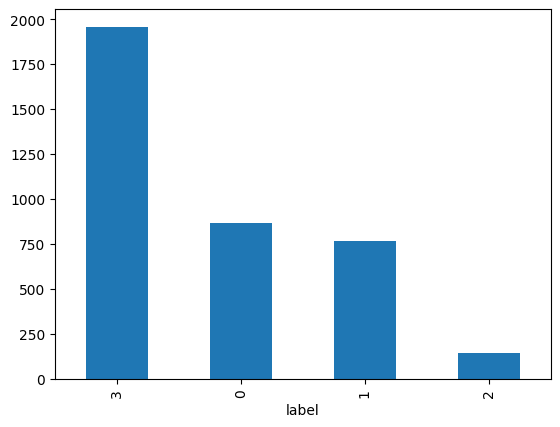

In [39]:
# 분류 레이블 값 분포 확인
train_data['label'].value_counts().plot(kind='bar')

In [40]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0    865
1      1    769
2      2    144
3      3   1958


In [41]:
# null값 확인하기
train_data.isnull().sum()

질문       0
label    0
dtype: int64

In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3736 entries, 1723 to 4022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      3736 non-null   object
 1   label   3736 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.6+ KB


In [43]:
# 전처리 _ 특수문자 등 한글만 남기고 제거하기.
# 정규 표현식 사용
train_data['질문'] = train_data['질문'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\2510707911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['질문'] = train_data['질문'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


,질문,label
1723,행사장같은곳에서 간단히먹을수있는 음식을 제조해서 무료로 나눠줄려고해도 식품위생법에 ...,1
1438,초당순두부로 집에서 간단시 할수 있는 요리가 뭐가 있나요,1
1891,계란이랑 김치만 넣고 만들수있는 밥 있나요,1
4700,마른 미역이 생겼는데 미역으로 할 수 있는 요리가 뭐가 있지요,3
465,벌써월 첫날이네요 오늘 저녁집밥메인메뉴로 오징어볶음 계란후라이 북어국 갈치구이...,0


In [44]:
# label -> 0: 음식, 1: 재료,  2: 추천, 3: 기타
train_data[train_data['label'] == 2]

,질문,label
2122,일식 양식 요리 레시피책 추천 부탁드립니다 유명한 셰프가 쓴거면 더욱 좋아요,2
2182,한식 양식 등등 요리대회 관련해서 참고할 수 있는 플레이팅 도서나 레시피 도서 추...,2
2246,자취생 간단히 밥 해 먹을 수 있는 거 추천 좀,2
2232,부부동반으로 스파여행을 갑니다 비발디 오션월드구요 팬션을 잡았어요 ...,2
2252,사진에 있는 제품으로 오븐과 베이킹틀을 이용해서 고든램지식으로 요리하려고 하는데 틀...,2
...,...,...
2230,마켓컬리 존맛탱 밀키트 추천,2
2277,안녕하세요 여수 아쿠아플라넷 들린 다음에 베네치아 호텔로 갈거 같은데요 저녁을 나...,2
2258,통풍 초기 증상이 있는데요 알칼리성식품 을 먹어야한다는데 알칼리성식품 종류가...,2
2184,집밥이 정말 토할정도로 맛없고 집에 요리를 할 줄 아는 사람이 아예 없어서 그...,2


In [45]:
# 공백만 있거나 빈값을 가진 행이 있다면 null값으로 변경하고 확인
train_data['질문'] = train_data['질문'].str.replace('^ +', "",regex=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\1941158316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['질문'] = train_data['질문'].str.replace('^ +', "",regex=True)


In [46]:
train_data['질문'].replace('', np.nan, inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\3777898010.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['질문'].replace('', np.nan, inplace=True)
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\3777898010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['질문'].replace('', np.nan, inplace=True)


In [47]:
print(train_data.isnull().sum())

질문       1
label    0
dtype: int64


In [48]:
# null값인 행 삭제하기
train_data.dropna(subset=['질문'], inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\3261527192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(subset=['질문'], inplace=True)


In [49]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3735 entries, 1723 to 4022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      3735 non-null   object
 1   label   3735 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.5+ KB


In [50]:
#  테스트 데이터 전처리
test_data.drop_duplicates(subset=['질문'], inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\1024044446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset=['질문'], inplace=True)


In [51]:
test_data['질문'] = test_data['질문'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\2820495892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['질문'] = test_data['질문'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


In [52]:
test_data['질문'] = test_data['질문'].str.replace('^ +', "", regex= True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\2804453816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['질문'] = test_data['질문'].str.replace('^ +', "", regex= True)


In [53]:
test_data['질문'].replace('', np.nan, inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\3601569623.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['질문'].replace('', np.nan, inplace=True)
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8964\3601569623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['질문'].replace('', np.nan, inplace=True)


In [54]:
test_data = test_data.dropna(how= 'any')

In [55]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 956 entries, 204 to 1215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      956 non-null    object
 1   label   956 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 22.4+ KB


3)토큰화

In [56]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [57]:
# Okt를 사용하여 형태소 분석
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [58]:
# train_data 에 형태소 분석기를 사용하여 토큰화, 불용어 제거 후 X_train에 저장하기
# tqdm -> terminal 또는 notebook 자동으로 진행상태를 시각적으로 보여주는 라이브러리
X_train=[]
for sentence in tqdm(train_data['질문']):
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 3735/3735 [00:22<00:00, 164.03it/s]


In [59]:
X_train[:3]

[['행사',
  '장',
  '같다',
  '곳',
  '에서',
  '간단하다',
  '먹다',
  '음식',
  '을',
  '제조',
  '무료',
  '로',
  '나누다',
  '해도',
  '식품위생법',
  '등록',
  '되다',
  '있다'],
 ['초당', '순두부', '로', '집', '에서', '간단', '시', '있다', '요리', '뭐', '있다'],
 ['계란', '이랑', '김치', '만', '넣다', '만들다', '밥', '있다']]

In [60]:
X_test = []
for sentence in tqdm(test_data['질문']):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 956/956 [00:05<00:00, 176.35it/s]


4) 정수인코딩

In [61]:
# 훈련데이터에 대해서 단어집합 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [62]:
# 단어집합 생성 및 각 단어에 고유 index 부여 확인
tokenizer.word_index

{'있다': 1,
 '먹다': 2,
 '을': 3,
 '요리': 4,
 '로': 5,
 '레시피': 6,
 '요': 7,
 '알다': 8,
 '에서': 9,
 '같다': 10,
 '제': 11,
 '되다': 12,
 '만들다': 13,
 '음식': 14,
 '없다': 15,
 '추천': 16,
 '좋다': 17,
 '안': 18,
 '이다': 19,
 '해주다': 20,
 '집': 21,
 '수': 22,
 '보다': 23,
 '저': 24,
 '것': 25,
 '만': 26,
 '다': 27,
 '간단하다': 28,
 '어떻다': 29,
 '때': 30,
 '싶다': 31,
 '메뉴': 32,
 '아니다': 33,
 '고': 34,
 '넣다': 35,
 '맛있다': 36,
 '너무': 37,
 '인데': 38,
 '나': 39,
 '정도': 40,
 '들다': 41,
 '좋아하다': 42,
 '집밥': 43,
 '않다': 44,
 '부탁드리다': 45,
 '중': 46,
 '많이': 47,
 '뭐': 48,
 '거': 49,
 '가다': 50,
 '못': 51,
 '이나': 52,
 '분': 53,
 '밥': 54,
 'ㅠㅠ': 55,
 '그렇다': 56,
 '하고': 57,
 '저녁': 58,
 '자다': 59,
 '랑': 60,
 '생각': 61,
 '재료': 62,
 '면': 63,
 '맛': 64,
 '많다': 65,
 '더': 66,
 '그': 67,
 '괜찮다': 68,
 '모르다': 69,
 '그냥': 70,
 '안녕하다': 71,
 '적': 72,
 '이랑': 73,
 '그리고': 74,
 '궁금하다': 75,
 '게': 76,
 '곳': 77,
 '시간': 78,
 '김치': 79,
 '해': 80,
 '살': 81,
 '이렇다': 82,
 '자취': 83,
 '개': 84,
 '계란': 85,
 '나오다': 86,
 '해보다': 87,
 '전': 88,
 '반찬': 89,
 '방법': 90,
 '걸': 91,
 '서': 92,
 '일': 9

In [63]:
total_cnt = len(tokenizer.word_index)

In [64]:
#  단어 집합의 최대 크기 제한
#  0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9351


In [65]:
#  텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [66]:
X_train[:3]

[[2195,
  528,
  10,
  77,
  9,
  28,
  2,
  14,
  3,
  2813,
  3272,
  5,
  1098,
  311,
  5411,
  380,
  12,
  1],
 [5412, 1250, 5, 21, 9, 762, 111, 1, 4, 48, 1],
 [85, 73, 79, 26, 35, 13, 54, 1]]

In [67]:
len(X_train)

3735

In [68]:
# train_data에서 y_train과 y_test를 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [69]:
len(y_train)

3735

6) 패딩

질문의 최대 길이 :  1102
질문의 평균 길이 :  36.397054886211514


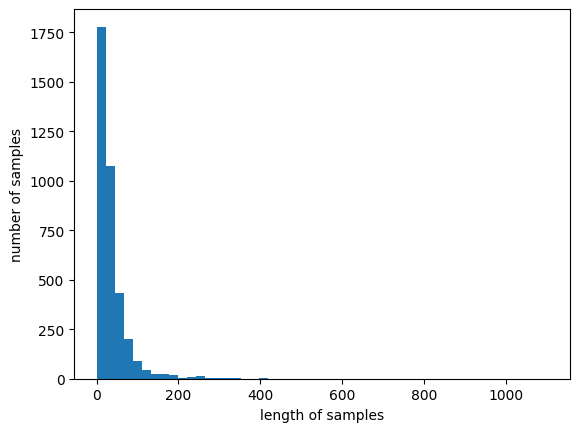

In [70]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업
print('질문의 최대 길이 : ', max(len(question) for question in X_train))
print('질문의 평균 길이 : ', sum(map(len, X_train)) / len(X_train))
plt.hist([len(question) for question in X_train], bins =50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [71]:

# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율 확인
def below_threshold_len(max_len, nested_list):
    count =0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (count / len(nested_list))*100))

In [75]:
#  max_len을 160 이하인 샘플의 비율 확인(250: 99.16, 150: 97.45 )
max_len =160
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 160 이하인 샘플의 비율 : 97.85809906291834


In [76]:
# 모든 샘플의 길이를 160로 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

2. CNN 모델 사용


#활성화함수 : relu, 소프트 맥스 함수, 손실함수 : 크로스 엔트로피함수

#하이퍼파라미터인 배치크기 : 64, 에포크 :100

#EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미

#ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만모델을 저장

#validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인

#검증데이터는 기계가 훈련 데이터에 과적합 되고 있지는 않은지 확인하기 위한 용도로 사용됨.

In [77]:
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import os

In [78]:
# 실제 레이블을 원-핫 인코딩
y_train_onehot = to_categorical(y_train, num_classes=4)
y_test_onehot = to_categorical(y_test, num_classes=4)

In [79]:
embedding_dim = 100
num_filters = 128
kernel_size = 5
dropout_rate = 0.5

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = X_train.shape[1])) # 단어를 고정된 차원으로 임베딩
model.add(Conv1D(num_filters, kernel_size, activation = 'relu')) # 1차원 컨볼루션 레이어를 사용하여 텍스트 데이터 처리
model.add(GlobalMaxPooling1D()) #  최대 풀링을 통해 차원 축소
model.add(Dropout(dropout_rate)) # 과적합 방지를 위해 드롭아웃 사용
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(4, activation='softmax'))  # 완전 연결 층을 추가하여 출력층에서 소프트맥스 함수를 사용하여 각 클래스의 확률 계산


# 모델 저장 디렉토리 확인 및 생성
model_dir = './model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 조기종료 및 모델 체크포인트 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(filepath=os.path.join(model_dir, 'best_model.h5'),  monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # 옵티마이저로 adam,  손실함수로 categorical_crossentropy 사용하여 모데 컴파일


# 모델 학습
history = model.fit(X_train, y_train_onehot, epochs=100, callbacks=[es, mc], batch_size=64, validation_data= (X_test, y_test_onehot))

# 디버깅: 체크포인트 파일 확인
if os.path.exists(os.path.join(model_dir, 'best_model.h5')):
    print("모델이 성공적으로 저장되었습니다.")
else:
    print("모델이 저장되지 않았습니다. 경로를 확인하세요.")

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 1.1864 - accuracy: 0.5025
Epoch 1: val_accuracy improved from -inf to 0.54393, saving model to ./model\best_model.h5
59/59 [==============================] - 9s 139ms/step - loss: 1.1864 - accuracy: 0.5025 - val_loss: 1.1097 - val_accuracy: 0.5439
Epoch 2/100
58/59 [============================>.] - ETA: 0s - loss: 1.0598 - accuracy: 0.5633
Epoch 2: val_accuracy improved from 0.54393 to 0.71548, saving model to ./model\best_model.h5
59/59 [==============================] - 9s 158ms/step - loss: 1.0580 - accuracy: 0.5641 - val_loss: 0.8365 - val_accuracy: 0.7155
Epoch 3/100
58/59 [============================>.] - ETA: 0s - loss: 0.6436 - accuracy: 0.7686
Epoch 3: val_accuracy improved from 0.71548 to 0.85042, saving model to ./model\best_model.h5
59/59 [==============================] - 4s 64ms/step - loss: 0.6435 - accuracy: 0.7687 - val_loss: 0.4523 - val_accuracy: 0.8504
Epoch 4/100
59/59 [=========================

In [80]:
# 훈련 종료 후 테스트데이터에 대해서 정확도를 측정. 훈련과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5' 로드
loaded_model  = load_model(os.path.join(model_dir, 'best_model.h5'))
# 테스트 정확도 평가
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_onehot)
print("\n 테스트 정확도: %.4f" % test_accuracy)

30/30 [==============================] - 0s 8ms/step - loss: 0.3361 - accuracy: 0.9299

 테스트 정확도: 0.9299


In [81]:
# 토크나이저 파일로 저장 후 로드
with open ('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

with open('tokenizer.pickle','rb') as handle:
    tokenizer = pickle.load(handle)

3. 리뷰 예측해보기

In [61]:
# 임의의 리뷰에 대해서 예측하는 함수 만들기
# 기본적으로 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용.
# model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 함

In [93]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',new_sentence)
    new_sentence = okt.morphs(new_sentence, stem = True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords]  # 불용어제거

    encoded = tokenizer.texts_to_sequences([new_sentence])  # 정수 인코딩
    pad_new = pad_sequences (encoded, maxlen = max_len)  # 패딩

    predictions = loaded_model.predict(pad_new)  # 3개의 클래스에 대한 확률 예측

    #  예측 결과 출력
    class_names = ['음식','재료', '추천', '기타']
    predicted_class = np.argmax(predictions, axis=1)[0]

    # 각 클래스에 대한 확률 출력
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]*100:.2f}% 확률")

    print(f"\n예측된 클래스: {class_names[predicted_class]}")


In [94]:
sentiment_predict('김치찌개 어케 만들까')

1/1 [==============================] - 0s 19ms/step
음식: 99.99% 확률
재료: 0.00% 확률
추천: 0.01% 확률
기타: 0.00% 확률

예측된 클래스: 음식


In [95]:
sentiment_predict('감자로 만들수 있는 요리')

1/1 [==============================] - 0s 25ms/step
음식: 0.15% 확률
재료: 99.82% 확률
추천: 0.03% 확률
기타: 0.00% 확률

예측된 클래스: 재료


In [96]:
sentiment_predict('소고기')

1/1 [==============================] - 0s 20ms/step
음식: 3.86% 확률
재료: 53.78% 확률
추천: 19.59% 확률
기타: 22.76% 확률

예측된 클래스: 재료


In [97]:
sentiment_predict('레시피 추천해줘')

1/1 [==============================] - 0s 12ms/step
음식: 0.21% 확률
재료: 0.37% 확률
추천: 13.21% 확률
기타: 86.22% 확률

예측된 클래스: 기타


In [98]:
sentiment_predict('된장찌개 만드는법 ')

1/1 [==============================] - 0s 23ms/step
음식: 99.88% 확률
재료: 0.01% 확률
추천: 0.11% 확률
기타: 0.00% 확률

예측된 클래스: 음식


In [99]:
sentiment_predict('요리순서 알려줘 ')

1/1 [==============================] - 0s 62ms/step
음식: 0.00% 확률
재료: 0.01% 확률
추천: 0.20% 확률
기타: 99.79% 확률

예측된 클래스: 기타


분류가 0,1(음식/재료)인 경우에만 레시피 추천 코드 실행

# 의도분류모델을 로드한 후, 의도분류 모델과 레시피 추천 기능을 결헙한 코드 작성

In [100]:
import os
import re
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from konlpy.tag import Okt

In [101]:
reci = pd.read_csv('E:/더조은/프로젝트/NEW_3/10000recipe Preprocessing.csv')
reci.head()

,Unnamed: 0,레시피일련번호,조리순서,레시피제목,요리명,등록자ID,등록자명,조회수,추천수,스크랩수,요리방법별명,요리상황별명,요리재료별명,요리종류별명,요리소개,요리재료내용,요리인분명,요리난이도명,요리시간명,최초등록일시
0,0,6852249,[조리순서]\n1.밥은 넓은 접시에 펼쳐 뜨거운 김을 날린다.밥 1공기\n2.양념장...,백전백승! 실패없는 김치볶음밥,김치볶음밥,gdubu33,만개의레시피,366065,1324,6914,볶음,일상,쌀,밥/죽/떡,이 레시피대로만 따라하면 절대! 실패따윈 두려워 하지 않아도 되! 세상의 모든 레...,[필수재료] 밥 1공기| 다진 양파 3큰술| 다진 김치 1/2컵| 다진 햄 3큰술 ...,1인분,아무나,15분이내,20160706123205
1,1,6859485,[조리순서]\n1.감자는 손질하여 한입 크기로 썰어 준비한다.감자 2개(360g)감...,매일 먹는 밑반찬 메뉴로 추천!! 감자조림,감자조림,gdubu33,만개의레시피,478527,1102,8221,조림,일상,채소류,밑반찬,만들어두면 마음&배가 든든해지는 달큰 짭잘 감자조림! 세상의 모든 레시피 만개의레시피,[필수재료] 감자 2개(360g)| 물 1cup [양념재료] 간장 5T| 설탕 1T...,2인분,아무나,30분이내,20161031112035
2,2,6846655,[조리순서]\n1.물 한 컵에 돼지고기를 넣고 끓여주세요물 대신 쌀뜨물을 사용하시면...,새마을식당 7분김치찌개 만들기,김치찌개,76918586,임루시,218649,1077,7594,끓이기,일상,채소류,찌개,새마을식당 김치찌개 따라잡기,[재료] 김치| 돼지고기(찌개용)| 양파 1/2개| 파 약간 [양념] 김치국물 2~...,2인분,아무나,15분이내,20160418201815
3,3,6841008,[조리순서]\n1.재료는 먹기 좋은 크기도 썰어서 준비해주세요^^\n2.고추장 2스...,백종원 제육볶음 레시피^^ 백종원의 노하우가 들어있는 손쉬운 레시피 백종원 제육볶음...,제육볶음,only1a2a3a,랑이의보물상자,976200,915,12418,볶음,술안주,돼지고기,메인반찬,백종원의 제육볶음 레시피로 간단하게 밥반찬 또는 야식 술안주 뚝딱 만들어봤습니다^^,[재료] 돼지고기 600g| 양파 1개| 청양고추 2개| 대파 1뿌리 [양념] 설탕...,4인분,아무나,30분이내,20160103095322
4,4,6857726,[조리순서]\n1.고등어는 내장을 제거하시고 핏물이 남지 않도록 깨끗이 씻어 준비합...,비린내 걱정없는 백종원 고등어조림,고등어조림,heeya120608,심술이네집밥이야기,297242,887,10924,조림,일상,해물류,메인반찬,집밥 백선생 시즌 2에서 소개된 비린내 없이 맛있게 만들수 있는 백종원씨의 고등어...,[재료] 고등어 2마리| 무| 양파| 대파| 청양고추 [양념] 설탕 1큰술| 다진마...,4인분,초급,60분이내,20160930162922


In [147]:
# 음식명과 재료명 단어사전 로드
# 음식명 단어사전 파일 불러오기
with open ('food_names.txt', 'r', encoding = 'utf-8') as file:
    food_names =[line.strip() for line in file.readlines()]

In [148]:
# 재료명 단어사전 임의로 만들기
ingredient_names =['감자','호박','두부','김치','돼지고기','소고기','고등어','무','오이']

In [149]:
# 사전 학습된 의도분류 모델 로드
loaded_model  = load_model(os.path.join(model_dir, 'best_model.h5'))

In [150]:
# 토크나이저 및 기타 필요한 전처리요소
okt = Okt()

In [151]:
def preprocess_text(text):
    # 한글과 공백을 제외한 모든 문자 제거
    text = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', text)
    #형태소 분석을 통해 토큰화
    tokens = okt.morphs(text, stem = True)
    return ' '.join(tokens)

In [152]:
def predict_intent(text):
    processed_text = preprocess_text(text)
    # 토큰을 정수 인덱스로 변환하고 패딩
    sequences = tokenizer.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    # 의도 분류 모델을 사용하여 예측
    prediction = loaded_model.predict(padded_sequences)
    return np.argmax(prediction)


In [153]:
#  텍스트를 n-그램으로 벡터화하기
def ngram_vectorize(texts, n=2):  # n=2 : 연속된 두 문자씩의 조합
    # CountVectorizer 초기화 - 문자 단위로 분석수행.
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n))
    # 텍스트 데이터 벡터화 - n그램 생성, 벡터화
    vectors = vectorizer.fit_transform(texts)
    # 벡터 배열로 변환
    return vectors.toarray(), vectorizer

In [154]:
# 두벡터간의 코사인 유사도 계산하여 반환하는 함수 정의
def cosine_similarity_score(v1, v2):
    # 두 벡터간의 코사인 유사도 계산(완전히 동일하면 1, 완전히 반대방향이면 -1, 서로 직교하면 0)
    return cosine_similarity([v1], [v2])[0][0]

In [155]:
# 레시피 추천함수(조회수가 높고 스크랩수가 많은 순으로 3개 추천)
def recommend_recipe(request):
    max_similarity = 0
    best_matches = []

    request_vector, vectorizer = ngram_vectorize([request])
    request_vector = request_vector[0]

    for index, row in reci.iterrows():
        word = row['요리명']
        word_vector = vectorizer.transform([word]).toarray()[0]
        similarity = cosine_similarity_score(request_vector, word_vector)
        
        # 사용자 입력과 음식명 사이의 유사도가 높을 때만 업데이트
        if similarity > 0.5:
            best_matches.append((similarity,row))

    # 가장 유사한 음식명에 대응하는 응답 텍스트 생성
    if best_matches:
        best_matches.sort(key = lambda x: (x[1]['조회수'], x[1]['스크랩수']), reverse = True)
        responses =[]

        for i, match in enumerate(best_matches[:3], start=1):  # 최대 3개까지 출력
            response = f"\n<{i}. {match[1]['레시피제목']}>\n\n{match[1]['요리재료내용']}\n{match[1]['조리순서']}"
            if i == 1:
                response = f"{match[1]['요리명']} 레시피를 알려드리겠습니다.\n" + response
            responses.append(response)

        return '\n'.join(responses)
    
    return '음식명으로 검색해주세요^^'

In [159]:
# 사용자가 입력한 재료를 기반으로 레시피 추천 함수
def recommend_recipe_by_ingredients():
    ingredients = []

    for i in range(3):
        ingredient = input(f"재료 {i+1}를 입력하세요: ")
        ingredient.append(ingredient)

    # 레시피 추천을 위해 입력한 재료와 가장 유사한 레시피를 조회수와 스크랩수가 높은 순으로 3개 추천
    recommendations = recommend_recipe_by_ingredients_helper(ingredients, num_recommendations=3)

    responses =[]
    for i , row in enumerate(recommendations, start =1):
        response = f"\n<{i}. {row['레시피제목']}>\n\n{row['요리재료내용']}\n{row['조리순서']}"
        response.append(response)

        return '\n'.join(response)
    
def recommend_recipe_by_ingredients_helper(ingredients, num_recommendations):
    # 사용자가 입력한 재료와 레시피 데이터의 재료를 비교하여 유사성 평가
    similarity_scores =[]

    for index, row in reci.iterrows():
        recipe_ingredients = row['요리재료내용'].split(',') # 레시피 데이터의 재료 가져오기
        similarity = calculate_similarity(ingredients, recipe_ingredients) # 재료 유사성 계산
        similarity_scores.append((similarity, row))
        
    # 유사성에 따라 레시피 정렬
    similarity_scores.sort(reverse = True)

    # 조회수가 높고 스크랩수가 많은 순으로 정렬된 레시피 반환
    recommendations = [score[1] for score in similarity_scores[:num_recommendations]]
    return recommendations    


def calculate_similarity(ingredients1, ingredients2):
    set1 = set(ingredients1)
    set2 = set(ingredients2)

    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    if union == 0:
        return 0
    else:
        return intersection / union

In [160]:
# 최종 챗봇 함수
def chat(request):
    #음식명 단어사전 및 재료명 단어사전을 사용한 검증
    if any(food in request for food in food_names):
        intent  = 0 # 음식명 관련 질문으로 분류
    elif any(ingredient in request for ingredient in ingredient_names):
        intent = 1 # 재료명 관련 질문으로 분류
    else:
        #의도 분류 수행
        intent = predict_intent(request)

    

    # 의도 분류가 음식명(0) 또는 재료(1)일때만 레시피 추천 수행
    if intent ==0:
        return recommend_recipe(request)
    elif intent ==1 :
        # 사용자에게 재료 입력 요청(3가지)
        return recommend_recipe_by_ingredients()
    else:
        return '음식이나 재료로 검색해주세요'

In [ ]:
# 예시 입력
while True:
    req = input("채팅을 입력하세요! (종료하려면 '끝'을 입력하세요): ")
    if req == '끝':
        break
    else:
        print('You : ' , req)
        print("쿠킹파트너 : ", chat(req))

요리재료내용 컬럼 전처리

In [173]:
df_ingredient = pd.read_csv('./전처리.csv')
df_ingredient.head()

,요리명,요리재료내용
0,김치볶음밥,"[필수재료] 밥, 다진 양파, 다진 김치, 다진 햄, 김칫국물, 고추장, 부순 참깨..."
1,감자조림,"[필수재료] 감자, 물, 설탕, 물엿, 다진 마늘, 참깨, 참기름"
2,김치찌개,"[재료] 김치, 돼지고기(찌개용), 양파, 파 [양념] 김치국물, 간장, 고춧가루..."
3,제육볶음,"[재료] 돼지고기, 양파, 청양고추, 대파, 고추장, 간장, 고춧가루, 다진마늘, ..."
4,고등어조림,"[재료] 고등어, 무, 양파, 대파, 청양고추 [양념] 설탕, 다진마늘, 다진생강,..."


In [237]:
def clean_ingredients(ingredients):
    # 대괄호와 괄호 안의 내용 모두 제거하기
    cleaned_ingredients = re.sub(r'\[.*?\]|\(.*?\)','', ingredients)
    #(,를 ,로 대체
    cleaned_ingredients = cleaned_ingredients.replace('(,',',')
    cleaned_ingredients = re.sub(r'/.*?(,|$)',',', cleaned_ingredients)
    cleaned_ingredients = cleaned_ingredients.rstrip(',')
    
    return cleaned_ingredients 

def clean_data(data):
    # 대괄호 안의 문자열 제거하고, 대괄호 앞에 쉼표 추가
    cleaned_data = re.sub(r'\[.*?\]', '', data)
    cleaned_data = re.sub(r'\(.*?\)', '', cleaned_data)
    #쉼표와 공백을 기준으로 데이터 분할 후 공백 제거
    data_list = re.split(r',\s*|\s+', cleaned_data)
    #  공백이 아닌 문자열만 선택하여 조인
    cleaned_data = ','.join(filter(None, set(data_list)))
    return cleaned_data.strip() # 양쪽 공백 제거



In [234]:
data = '[재료] 고등어, 무, 양파, 대파, 청양고추 [양념] 설탕, 다진마늘, 다진생강'

In [235]:
cleaned_data = clean_data(data)

In [236]:
cleaned_data

'다진마늘,대파,무,청양고추,양파,고등어,설탕,다진생강'

In [238]:
df_ingredient['요리재료내용']  = df_ingredient['요리재료내용'].apply(clean_data)

In [ ]:
df_ingredient.to_csv('./전처리.csv', index=False)
df_ingredient = pd.read_csv('./전처리.csv')
df_ingredient

In [260]:
df_ingredient = pd.read_excel('./전처리.xlsx')
df_ingredient

,요리명,요리재료내용,요리재료내용_Okt,Nouns_Okt,요리재료내용_Komoran,Nouns_Komoran
0,김치볶음밥,"밥, 다진양파, 다진김치, 다진햄, 설탕, 김칫국물, 고추장, 부순참깨, 들기름","[('밥', 'Noun'), (',', 'Punctuation'), ('다진', '...","['밥', '양파', '김치', '햄', '설탕', '김칫국', '물', '고추장'...","[('밥', 'NNG'), (',', 'SP'), ('다지', 'VV'), ('ㄴ'...","['밥', '양파', '김치', '햄', '설탕', '김칫국', '물', '고추장'..."
1,감자조림,"감자, 물, 간장, 설탕, 물엿, 다진마늘, 참깨, 참기름","[('감자', 'Noun'), (',', 'Punctuation'), ('물', '...","['감자', '물', '간장', '설탕', '물엿', '마늘', '참깨', '참기름']","[('감자', 'NNP'), (',', 'SP'), ('물', 'NNG'), (',...","['감자', '물', '간장', '설탕', '물엿', '마늘', '참깨', '참기름']"
2,김치찌개,"김치, 돼지고기, 양파, 파, 김치국물, 간장, 고춧가루, 다진마늘, 다시다","[('김치', 'Noun'), (',', 'Punctuation'), ('돼지고기'...","['김치', '돼지고기', '양파', '파', '김치', '국물', '간장', '고...","[('김치', 'NNP'), (',', 'SP'), ('돼지고기', 'NNP'), ...","['김치', '돼지고기', '양파', '파', '김치', '국물', '간장', '고..."
3,제육볶음,"돼지고기, 양파, 청양고추, 대파, 설탕, 고추장, 간장, 고춧가루, 다진마늘, 굴...","[('돼지고기', 'Noun'), (',', 'Punctuation'), ('양파'...","['돼지고기', '양파', '청양고추', '대파', '설탕', '고추장', '간장'...","[('돼지고기', 'NNP'), (',', 'SP'), ('양파', 'NNP'), ...","['돼지고기', '양파', '청양고추', '대파', '설탕', '고추장', '간장'..."
4,고등어조림,"고등어, 무, 양파, 대파, 청양고추, 설탕, 다진마늘, 다진생강, 된장, 진간장,...","[('고등어', 'Noun'), (',', 'Punctuation'), ('무', ...","['고등어', '무', '양파', '대파', '청양고추', '설탕', '마늘', '...","[('고등어', 'NNG'), (',', 'SP'), ('무', 'XPN'), ('...","['고등어', '양파', '대파', '청양고추', '설탕', '마늘', '생강', ..."
...,...,...,...,...,...,...
1495,김치볶음밥,"김치, 밥, 모짜렐라치즈, 계란, 들기름, 고추가루","[('김치', 'Noun'), (',', 'Punctuation'), ('밥', '...","['김치', '밥', '모짜렐라', '치즈', '계란', '들기름', '고추', '...","[('김치', 'NNP'), (',', 'SP'), ('밥', 'NNG'), (',...","['김치', '밥', '모', '짜', '레', '라', '치즈', '계란', '들..."
1496,라면,"라면, 물, 대파, 다진생강, 다진마늘, 고춧가루, 참기름, 식용유","[('라면', 'Noun'), (',', 'Punctuation'), ('물', '...","['라면', '물', '대파', '생강', '마늘', '고춧가루', '참기름', '...","[('라면', 'NNP'), (',', 'SP'), ('물', 'NNG'), (',...","['라면', '물', '대파', '생강', '마늘', '고춧가루', '참기름', '..."
1497,닭볶음탕,"닭, 김칫국물, 고구마, 당근, 양파, 파, 고추장, 고춧가루, 올리고당, 설탕, ...","[('닭', 'Noun'), (',', 'Punctuation'), ('김칫국', ...","['닭', '김칫국', '물', '고구마', '당근', '양파', '파', '고추장...","[('닭', 'NNG'), (',', 'SP'), ('김칫국', 'NNG'), ('...","['닭', '김칫국', '물', '고구마', '당근', '양파', '파', '고추장..."
1498,우엉조림,"우엉, 조청, 맛간장","[('우엉', 'Noun'), (',', 'Punctuation'), ('조청', ...","['우엉', '조청', '맛', '간장']","[('우엉', 'NNP'), (',', 'SP'), ('조청', 'NNP'), ('...","['우엉', '조청', '맛', '간장']"


In [269]:
# 요리재료 컬럼
ingredients_column = df_ingredient['요리재료내용']

In [270]:
# 모든 요리 재료를 담을 리스트를 초기화
all_ingredients =[]
# 각행의 요리 재료를 쉼표로 구분하여 리스트에 추가하기
for ingredients in ingredients_column:
    ingredients_list = ingredients.split(',')
    all_ingredients.extend(ingredients_list)


In [273]:
len(all_ingredients)

15460

In [274]:
from collections import OrderedDict

In [275]:
unique_word = list(OrderedDict.fromkeys(all_ingredients))

In [277]:
len(unique_word)

1453

In [271]:
# 리스트에 있는 요리 재료의 빈도 계산하기
ingredients_counts = pd.Series(all_ingredients).value_counts()

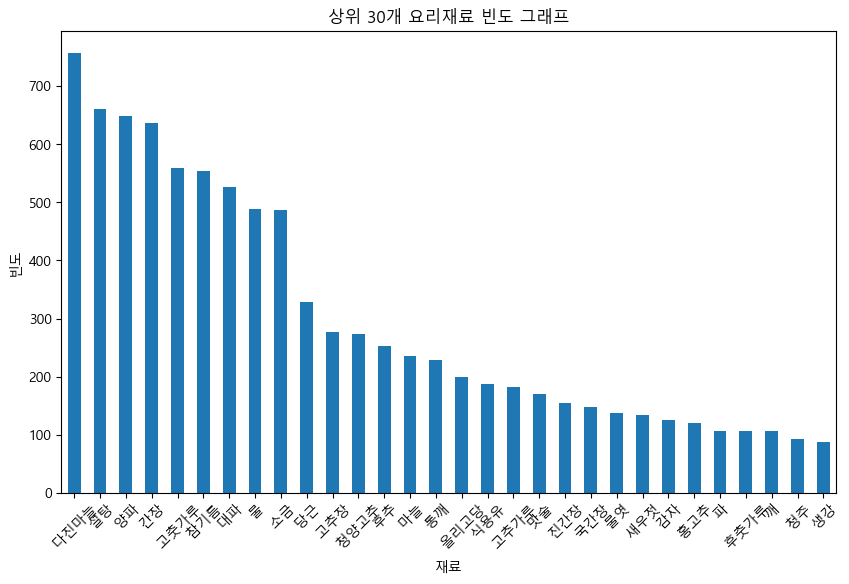

In [272]:
# 상위 N개의 요리 재료에 대한 그래프 그리기
top_n = 30
top_ingredients = ingredients_counts.head(top_n)

plt.figure(figsize=(10,6))
top_ingredients.plot(kind= 'bar')
plt.title('상위 {}개 요리재료 빈도 그래프'.format(top_n))
plt.xlabel('재료')
plt.ylabel('빈도')
plt.xticks(rotation = 45)
plt.show()

